In [2]:
import shap
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
pl.Config.set_tbl_width_chars(200)
plt.rcParams["figure.figsize"] = (20,10)


In [4]:
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [ ]:
data = pl.read_parquet("./data/modelling_data.parquet")

In [21]:
base_features = [
    "views",
    "likes",
    "dislikes",
    "comment_count",
    "comments_disabled",
    "ratings_disabled",
    "video_error_or_removed",
    "likes_to_dislikes",
    "likes_to_views",
    "comments_to_views",
    "trending_date_weekday",
]


historical_features = [
    "channel_num_trending_videos_last_7_days",
    "channel_max_days_in_trending_7_days",
    "channel_avg_days_in_trending_7_days",
    "channel_num_trending_videos_last_30_days",
    "channel_max_days_in_trending_30_days",
    "channel_avg_days_in_trending_30_days",
    "channel_num_trending_videos_last_180_days",
    "channel_max_days_in_trending_180_days",
    "channel_avg_days_in_trending_180_days",
    "general_num_trending_videos_last_7_days",
    "general_max_days_in_trending_7_days",
    "general_avg_days_in_trending_7_days",
    "general_num_trending_videos_last_30_days",
    "general_max_days_in_trending_30_days",
    "general_avg_days_in_trending_30_days",
    "general_num_trending_videos_last_180_days",
    "general_max_days_in_trending_180_days",
    "general_avg_days_in_trending_180_days",
]

categorical_features = ["category_id"]

### Train/Val/Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    data[base_features + historical_features + categorical_features],
    data["days_in_trending"],
    test_size=0.2,
)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = X_train.to_pandas()
X_val = X_val.to_pandas()
X_test = X_test.to_pandas()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, X_val.shape, X_test.shape

((2044, 30), (512, 30), (640, 30))

## Model

In [27]:
X_train[categorical_features] = X_train[categorical_features].astype("category")
X_val[categorical_features] = X_val[categorical_features].astype("category")
X_test[categorical_features] = X_test[categorical_features].astype("category")

In [28]:
lgbm = LGBMRegressor(
    num_iterations=20000,
    early_stopping_round=100,
    learning_rate=0.005,
    force_row_wise=True,
)
lgbm.fit(
    X_train,
    y_train,
    categorical_feature=categorical_features,
    eval_set=(X_val, y_val),
    verbose=0,
)

LGBMRegressor(early_stopping_round=100, force_row_wise=True,
              learning_rate=0.005, num_iterations=20000)

In [29]:
test_preds = lgbm.predict(X_test)
rmse = mean_squared_error(y_test, test_preds, squared=False)

print(rmse)

7.182044421233441


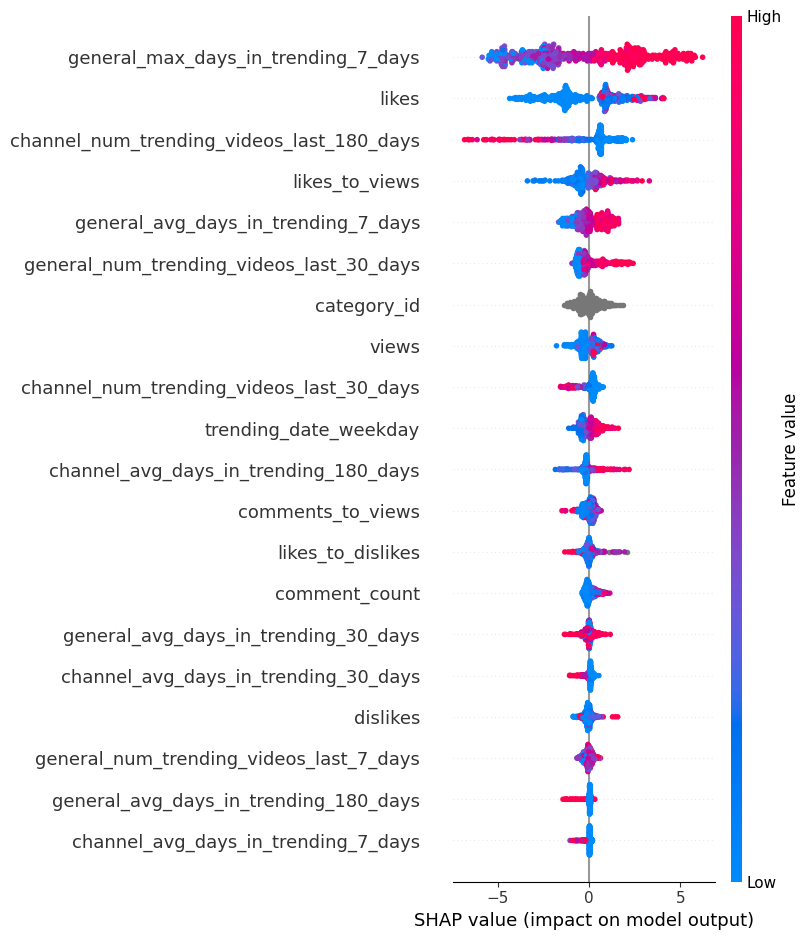

In [30]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, max_display=20)